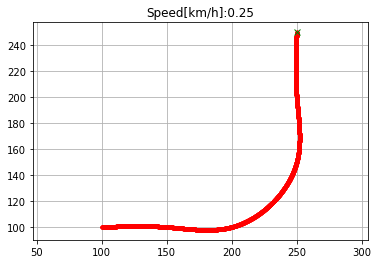

KeyboardInterrupt: 

In [1]:
"""
Path tracking simulation with Stanley steering control and PID speed control.
author: Atsushi Sakai (@Atsushi_twi)
Ref:
    - [Stanley: The robot that won the DARPA grand challenge](http://isl.ecst.csuchico.edu/DOCS/darpa2005/DARPA%202005%20Stanley.pdf)
    - [Autonomous Automobile Path Tracking](https://www.ri.cmu.edu/pub_files/2009/2/Automatic_Steering_Methods_for_Autonomous_Automobile_Path_Tracking.pdf)
"""
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../PathPlanning/CubicSpline/")

try:
    import cubic_spline_planner
except:
    raise


k = 0.5  # control gain
Kp = 1.0  # speed proportional gain
dt = 0.1  # [s] time difference
L = 15  # [cm] Wheel base of vehicle
max_steer = np.radians(90.0)  # [rad] max steering angle

show_animation = True


class State(object):
    """
    Class representing the state of a vehicle.
    :param x: (float) x-coordinate
    :param y: (float) y-coordinate
    :param yaw: (float) yaw angle
    :param v: (float) speed
    """

    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        """Instantiate the object."""
        super(State, self).__init__()
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v

    def update(self, acceleration, delta):
        """
        Update the state of the vehicle.
        Stanley Control uses bicycle model.
        :param acceleration: (float) Acceleration
        :param delta: (float) Steering
        """
        delta = np.clip(delta, -max_steer, max_steer)

        self.x += self.v * np.cos(self.yaw) * dt
        self.y += self.v * np.sin(self.yaw) * dt
        self.yaw += self.v / L * np.tan(delta) * dt
        self.yaw = normalize_angle(self.yaw)
        self.v += acceleration * dt


def pid_control(target, current):
    """
    Proportional control for the speed.
    :param target: (float)
    :param current: (float)
    :return: (float)
    """
    return Kp * (target - current)


def stanley_control(state, cx, cy, cyaw, last_target_idx):
    """
    Stanley steering control.
    :param state: (State object)
    :param cx: ([float])
    :param cy: ([float])
    :param cyaw: ([float])
    :param last_target_idx: (int)
    :return: (float, int)
    """
    current_target_idx, error_front_axle = calc_target_index(state, cx, cy)

    if last_target_idx >= current_target_idx:
        current_target_idx = last_target_idx

    # theta_e corrects the heading error
    theta_e = normalize_angle(cyaw[current_target_idx] - state.yaw)
    # theta_d corrects the cross track error
    theta_d = np.arctan2(k * error_front_axle, state.v)
    # Steering control
    delta = theta_e + theta_d

    return delta, current_target_idx


def normalize_angle(angle):
    """
    Normalize an angle to [-pi, pi].
    :param angle: (float)
    :return: (float) Angle in radian in [-pi, pi]
    """
    while angle > np.pi:
        angle -= 2.0 * np.pi

    while angle < -np.pi:
        angle += 2.0 * np.pi

    return angle


def calc_target_index(state, cx, cy):
    """
    Compute index in the trajectory list of the target.
    :param state: (State object)
    :param cx: [float]
    :param cy: [float]
    :return: (int, float)
    """
    # Calc front axle position
    fx = state.x + L * np.cos(state.yaw)
    fy = state.y + L * np.sin(state.yaw)

    # Search nearest point index
    dx = [fx - icx for icx in cx]
    dy = [fy - icy for icy in cy]
    d = np.hypot(dx, dy)
    target_idx = np.argmin(d)

    # Project RMS error onto front axle vector
    front_axle_vec = [-np.cos(state.yaw + np.pi / 2),
                      -np.sin(state.yaw + np.pi / 2)]
    error_front_axle = np.dot([dx[target_idx], dy[target_idx]], front_axle_vec)

    return target_idx, error_front_axle


def main():
    """Plot an example of Stanley steering control on a cubic spline."""
    #  target course
#     ax = [0.0, 100.0, 100.0, 50.0, 60.0]
#     ay = [0.0, 0.0, -30.0, -20.0, 0.0]
#     arrays=[[9, 146], [11, 146], [13, 146], [15, 146], [17, 146], [19, 146], [21, 146], [23, 146], [25, 146],
#             [27, 146], [29, 146], [31, 146], [33, 146], [35, 146], [37, 146], [39, 146], [41, 146], [43, 146],
#             [45, 146], [47, 146], [49, 146], [51, 146], [53, 146], [55, 146], [57, 146], [59, 146], [61, 146],
#             [63, 146], [65, 146], [67, 146], [69, 146], [71, 146], [73, 146], [75, 146], [77, 146], [79, 146],
#             [81, 146], [83, 146], [85, 146], [87, 146], [89, 146], [91, 146], [93, 146], [95, 146], [97, 146],
#             [99, 146], [101, 146], [103, 146], [105, 146], [107, 146], [109, 146], [111, 146], [113, 146],
#             [115, 146], [117, 146], [119, 146], [121, 146], [123, 146], [125, 146], [127, 146], [129, 146],
#             [131, 146], [133, 146], [135, 146], [137, 144], [139, 142], [141, 140], [143, 138], [143, 136],
#             [143, 134], [143, 132], [143, 130], [143, 128], [143, 126], [143, 124], [143, 122], [143, 120],
#             [143, 118], [143, 116], [143, 114], [143, 112], [143, 110], [143, 108], [143, 106], [143, 104],
#             [143, 102], [143, 100], [143, 98], [143, 96], [143, 94], [143, 92], [143, 90], [143, 88], [143, 86],
#             [143, 84], [143, 82], [143, 80], [143, 78], [143, 76], [143, 74], [143, 72], [143, 70], [143, 68],
#             [143, 66], [143, 64], [143, 62], [143, 60], [143, 58], [143, 56], [143, 54], [143, 52], [143, 50],
#             [143, 48], [143, 46], [143, 44], [143, 42], [143, 40], [143, 38], [143, 36], [143, 34], [143, 32],
#             [143, 30], [143, 28], [143, 26], [143, 24], [143, 22], [143, 20], [143, 18], [143, 16], [143, 14],
#             [145, 12], [147, 10], [149, 8]]

    #arrays = [(1, 268), (1, 269), (2, 266), (2, 267), (2, 268), (2, 269), (2, 270), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (3, 37), (3, 38), (3, 39), (3, 40), (3, 41), (3, 42), (3, 43), (3, 44), (3, 45), (3, 46), (3, 47), (3, 48), (3, 49), (3, 50), (3, 51), (3, 52), (3, 53), (3, 54), (3, 55), (3, 56), (3, 57), (3, 58), (3, 59), (3, 60), (3, 61), (3, 62), (3, 63), (3, 64), (3, 65), (3, 66), (3, 67), (3, 68), (3, 69), (3, 70), (3, 71), (3, 72), (3, 73), (3, 74), (3, 75), (3, 76), (3, 77), (3, 78), (3, 79), (3, 80), (3, 81), (3, 82), (3, 83), (3, 84), (3, 85), (3, 86), (3, 87), (3, 88), (3, 89), (3, 90), (3, 91), (3, 92), (3, 93), (3, 94), (3, 95), (3, 96), (3, 97), (3, 98), (3, 99), (3, 100), (3, 101), (3, 102), (3, 103), (3, 104), (3, 105), (3, 106), (3, 107), (3, 108), (3, 109), (3, 110), (3, 111), (3, 112), (3, 113), (3, 114), (3, 115), (3, 116), (3, 117), (3, 118), (3, 119), (3, 120), (3, 121), (3, 122), (3, 123), (3, 124), (3, 125), (3, 126), (3, 127), (3, 128), (3, 129), (3, 130), (3, 131), (3, 132), (3, 133), (3, 134), (3, 135), (3, 136), (3, 137), (3, 138), (3, 139), (3, 140), (3, 141), (3, 142), (3, 143), (3, 144), (3, 145), (3, 146), (3, 147), (3, 148), (3, 149), (3, 150), (3, 151), (3, 152), (3, 153), (3, 154), (3, 155), (3, 156), (3, 157), (3, 158), (3, 159), (3, 160), (3, 161), (3, 162), (3, 163), (3, 164), (3, 165), (3, 166), (3, 167), (3, 168), (3, 169), (3, 170), (3, 171), (3, 172), (3, 173), (3, 174), (3, 175), (3, 176), (3, 177), (3, 178), (3, 179), (3, 180), (3, 181), (3, 182), (3, 183), (3, 184), (3, 185), (3, 186), (3, 187), (3, 188), (3, 189), (3, 190), (3, 191), (3, 192), (3, 193), (3, 194), (3, 195), (3, 196), (3, 197), (3, 198), (3, 199), (3, 200), (3, 201), (3, 202), (3, 203), (3, 204), (3, 205), (3, 206), (3, 207), (3, 208), (3, 209), (3, 210), (3, 211), (3, 212), (3, 213), (3, 214), (3, 215), (3, 216), (3, 217), (3, 218), (3, 219), (3, 220), (3, 221), (3, 222), (3, 223), (3, 224), (3, 225), (3, 226), (3, 227), (3, 228), (3, 229), (3, 230), (3, 231), (3, 232), (3, 233), (3, 234), (3, 235), (3, 236), (3, 237), (3, 238), (3, 239), (3, 240), (3, 241), (3, 242), (3, 243), (3, 244), (3, 245), (3, 246), (3, 247), (3, 248), (3, 249), (3, 250), (3, 251), (3, 252), (3, 253), (3, 254), (3, 255), (3, 256), (3, 257), (3, 258), (3, 259), (3, 260), (3, 261), (3, 262), (3, 263), (3, 264), (3, 265), (3, 266), (3, 267), (3, 268), (3, 269), (3, 270), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (4, 32), (4, 33), (4, 34), (4, 35), (4, 36), (4, 37), (4, 38), (4, 39), (4, 40), (4, 41), (4, 42), (4, 43), (4, 44), (4, 45), (4, 46), (4, 47), (4, 48), (4, 49), (4, 50), (4, 51), (4, 52), (4, 53), (4, 54), (4, 55), (4, 56), (4, 57), (4, 58), (4, 59), (4, 60), (4, 61), (4, 62), (4, 63), (4, 64), (4, 65), (4, 66), (4, 67), (4, 68), (4, 69), (4, 70), (4, 71), (4, 72), (4, 73), (4, 74), (4, 75), (4, 76), (4, 77), (4, 78), (4, 79), (4, 80), (4, 81), (4, 82), (4, 83), (4, 84), (4, 85), (4, 86), (4, 87), (4, 88), (4, 89), (4, 90), (4, 91), (4, 92), (4, 93), (4, 94), (4, 95), (4, 96), (4, 97), (4, 98), (4, 99), (4, 100), (4, 101), (4, 102), (4, 103), (4, 104), (4, 105), (4, 106), (4, 107), (4, 108), (4, 109), (4, 110), (4, 111), (4, 112), (4, 113), (4, 114), (4, 115), (4, 116), (4, 117), (4, 118), (4, 119), (4, 120), (4, 121), (4, 122), (4, 123), (4, 124), (4, 125), (4, 126), (4, 127), (4, 128), (4, 129), (4, 130), (4, 131), (4, 132), (4, 133), (4, 134), (4, 135), (4, 136), (4, 137), (4, 138), (4, 139), (4, 140), (4, 141), (4, 142), (4, 143), (4, 144), (4, 145), (4, 146), (4, 147), (4, 148), (4, 149), (4, 150), (4, 151), (4, 152), (4, 153), (4, 154), (4, 155), (4, 156), (4, 157), (4, 158), (4, 159), (4, 160), (4, 161), (4, 162), (4, 163), (4, 164), (4, 165), (4, 166), (4, 167), (4, 168), (4, 169), (4, 170), (4, 171), (4, 172), (4, 173), (4, 174), (4, 175), (4, 176), (4, 177), (4, 178), (4, 179), (4, 180), (4, 181), (4, 182), (4, 183), (4, 184), (4, 185), (4, 186), (4, 187), (4, 188), (4, 189), (4, 190), (4, 191), (4, 192), (4, 193), (4, 194), (4, 195), (4, 196), (4, 197), (4, 198), (4, 199), (4, 200), (4, 201), (4, 202), (4, 203), (4, 204), (4, 205), (4, 206), (4, 207), (4, 208), (4, 209), (4, 210), (4, 211), (4, 212), (4, 213), (4, 214), (4, 215), (4, 216), (4, 217), (4, 218), (4, 219), (4, 220), (4, 221), (4, 222), (4, 223), (4, 224), (4, 225), (4, 226), (4, 227), (4, 228), (4, 229), (4, 230), (4, 231), (4, 232), (4, 233), (4, 234), (4, 235), (4, 236), (4, 237), (4, 238), (4, 239), (4, 240), (4, 241), (4, 242), (4, 243), (4, 244), (4, 245), (4, 246), (4, 247), (4, 248), (4, 249), (4, 250), (4, 251), (4, 252), (4, 253), (4, 254), (4, 255), (4, 256), (4, 257), (4, 258), (4, 259), (4, 260), (4, 261), (4, 262), (4, 263), (4, 264), (4, 265), (4, 266), (4, 267), (4, 268), (4, 269), (4, 270), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 31), (5, 32), (5, 33), (5, 34), (5, 35), (5, 36), (5, 37), (5, 38), (5, 39), (5, 40), (5, 41), (5, 42), (5, 43), (5, 44), (5, 45), (5, 46), (5, 47), (5, 48), (5, 49), (5, 50), (5, 51), (5, 52), (5, 53), (5, 54), (5, 55), (5, 56), (5, 57), (5, 58), (5, 59), (5, 60), (5, 61), (5, 62), (5, 63), (5, 64), (5, 65), (5, 66), (5, 67), (5, 68), (5, 69), (5, 70), (5, 71), (5, 72), (5, 73), (5, 74), (5, 75), (5, 76), (5, 77), (5, 78), (5, 79), (5, 80), (5, 81), (5, 82), (5, 83), (5, 84), (5, 85), (5, 86), (5, 87), (5, 88), (5, 89), (5, 90), (5, 91), (5, 92), (5, 93), (5, 94), (5, 95), (5, 96), (5, 97), (5, 98), (5, 99), (5, 100), (5, 101), (5, 102), (5, 103), (5, 104), (5, 105), (5, 106), (5, 107), (5, 108), (5, 109), (5, 110), (5, 111), (5, 112), (5, 113), (5, 114), (5, 115), (5, 116), (5, 117), (5, 118), (5, 119), (5, 120), (5, 121), (5, 122), (5, 123), (5, 124), (5, 125), (5, 126), (5, 127), (5, 128), (5, 129), (5, 130), (5, 131), (5, 132), (5, 133), (5, 134), (5, 135), (5, 136), (5, 137), (5, 138), (5, 139), (5, 140), (5, 141), (5, 142), (5, 143), (5, 144), (5, 145), (5, 146), (5, 147), (5, 148), (5, 149), (5, 150), (5, 151), (5, 152), (5, 153), (5, 154), (5, 155), (5, 156), (5, 157), (5, 158), (5, 159), (5, 160), (5, 161), (5, 162), (5, 163), (5, 164), (5, 165), (5, 166), (5, 167), (5, 168), (5, 169), (5, 170), (5, 171), (5, 172), (5, 173), (5, 174), (5, 175), (5, 176), (5, 177), (5, 178), (5, 179), (5, 180), (5, 181), (5, 182), (5, 183), (5, 184), (5, 185), (5, 186), (5, 187), (5, 188), (5, 189), (5, 190), (5, 191), (5, 192), (5, 193), (5, 194), (5, 195), (5, 196), (5, 197), (5, 198), (5, 199), (5, 200), (5, 201), (5, 202), (5, 203), (5, 204), (5, 205), (5, 206), (5, 207), (5, 208), (5, 209), (5, 210), (5, 211), (5, 212), (5, 213), (5, 214), (5, 215), (5, 216), (5, 217), (5, 218), (5, 219), (5, 220), (5, 221), (5, 222), (5, 223), (5, 224), (5, 225), (5, 226), (5, 227), (5, 228), (5, 229), (5, 230), (5, 231), (5, 232), (5, 233), (5, 234), (5, 235), (5, 236), (5, 237), (5, 238), (5, 239), (5, 240), (5, 241), (5, 242), (5, 243), (5, 244), (5, 245), (5, 246), (5, 247), (5, 248), (5, 249), (5, 250), (5, 251), (5, 252), (5, 253), (5, 254), (5, 255), (5, 256), (5, 257), (5, 258), (5, 259), (5, 260), (5, 261), (5, 262), (5, 263), (5, 264), (5, 265), (5, 266), (5, 267), (5, 268), (5, 269), (5, 270), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (6, 16), (6, 17), (6, 18), (6, 19), (6, 20), (6, 21), (6, 22), (6, 23), (6, 24), (6, 25), (6, 26), (6, 27), (6, 28), (6, 29), (6, 30), (6, 31), (6, 32), (6, 33), (6, 34), (6, 35), (6, 36), (6, 37), (6, 38), (6, 39), (6, 40), (6, 41), (6, 42), (6, 43), (6, 44), (6, 45), (6, 46), (6, 47), (6, 48), (6, 49), (6, 50), (6, 51), (6, 52), (6, 53), (6, 54), (6, 55), (6, 56), (6, 57), (6, 58), (6, 59), (6, 60), (6, 61), (6, 62), (6, 63), (6, 64), (6, 65), (6, 66), (6, 67), (6, 68), (6, 69), (6, 70), (6, 71), (6, 72), (6, 73), (6, 74), (6, 75), (6, 76), (6, 77), (6, 78), (6, 79), (6, 80), (6, 81), (6, 82), (6, 83), (6, 84), (6, 85), (6, 86), (6, 87), (6, 88), (6, 89), (6, 90), (6, 91), (6, 92), (6, 93), (6, 94), (6, 95), (6, 96), (6, 97), (6, 98), (6, 99), (6, 100), (6, 101), (6, 102), (6, 103), (6, 104), (6, 105), (6, 106), (6, 107), (6, 108), (6, 109), (6, 110), (6, 111), (6, 112), (6, 113), (6, 114), (6, 115), (6, 116), (6, 117), (6, 118), (6, 119), (6, 120), (6, 121), (6, 122), (6, 123), (6, 124), (6, 125), (6, 126), (6, 127), (6, 128), (6, 129), (6, 130), (6, 131), (6, 132), (6, 133), (6, 134), (6, 135), (6, 136), (6, 137), (6, 138), (6, 139), (6, 140), (6, 141), (6, 142), (6, 143), (6, 144), (6, 145), (6, 146), (6, 147), (6, 148), (6, 149), (6, 150), (6, 151), (6, 152), (6, 153), (6, 154), (6, 155), (6, 156), (6, 157), (6, 158), (6, 159), (6, 160), (6, 161), (6, 162), (6, 163), (6, 164), (6, 165), (6, 166), (6, 167), (6, 168), (6, 169), (6, 170), (6, 171), (6, 172), (6, 173), (6, 174), (6, 175), (6, 176), (6, 177), (6, 178), (6, 179), (6, 180), (6, 181), (6, 182), (6, 183), (6, 184), (6, 185), (6, 186), (6, 187), (6, 188), (6, 189), (6, 190), (6, 191), (6, 192), (6, 193), (6, 194), (6, 195), (6, 196), (6, 197), (6, 198), (6, 199), (6, 200), (6, 201), (6, 202), (6, 203), (6, 204), (6, 205), (6, 206), (6, 207), (6, 208), (6, 209), (6, 210), (6, 211), (6, 212), (6, 213), (6, 214), (6, 215), (6, 216), (6, 217), (6, 218), (6, 219), (6, 220), (6, 221), (6, 222), (6, 223), (6, 224), (6, 225), (6, 226), (6, 227), (6, 228), (6, 229), (6, 230), (6, 231), (6, 232), (6, 233), (6, 234), (6, 235), (6, 236), (6, 237), (6, 238), (6, 239), (6, 240), (6, 241), (6, 242), (6, 243), (6, 244), (6, 245), (6, 246), (6, 247), (6, 248), (6, 249), (6, 250), (6, 251), (6, 252), (6, 253), (6, 254), (6, 255), (6, 256), (6, 257), (6, 258), (6, 259), (6, 260), (6, 261), (6, 262), (6, 263), (6, 264), (6, 265), (6, 266), (6, 267), (6, 268), (6, 269), (6, 270), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 15), (7, 16), (7, 17), (7, 18), (7, 19), (7, 20), (7, 21), (7, 22), (7, 23), (7, 24), (7, 25), (7, 26), (7, 27), (7, 28), (7, 29), (7, 30), (7, 31), (7, 32), (7, 33), (7, 34), (7, 35), (7, 36), (7, 37), (7, 38), (7, 39), (7, 40), (7, 41), (7, 42), (7, 43), (7, 44), (7, 45), (7, 46), (7, 47), (7, 48), (7, 49), (7, 50), (7, 51), (7, 52), (7, 53), (7, 54), (7, 55), (7, 56), (7, 57), (7, 58), (7, 59), (7, 60), (7, 61), (7, 62), (7, 63), (7, 64), (7, 65), (7, 66), (7, 67), (7, 68), (7, 69), (7, 70), (7, 71), (7, 72), (7, 73), (7, 74), (7, 75), (7, 76), (7, 77), (7, 78), (7, 79), (7, 80), (7, 81), (7, 82), (7, 83), (7, 84), (7, 85), (7, 86), (7, 87), (7, 88), (7, 89), (7, 90), (7, 91), (7, 92), (7, 93), (7, 94), (7, 95), (7, 96), (7, 97), (7, 98), (7, 99), (7, 100), (7, 101), (7, 102), (7, 103), (7, 104), (7, 105), (7, 106), (7, 107), (7, 108), (7, 109), (7, 110), (7, 111), (7, 112), (7, 113), (7, 114), (7, 115), (7, 116), (7, 117), (7, 118), (7, 119), (7, 120), (7, 121), (7, 122), (7, 123), (7, 124), (7, 125), (7, 126), (7, 127), (7, 128), (7, 129), (7, 130), (7, 131), (7, 132), (7, 133), (7, 134), (7, 135), (7, 136), (7, 137), (7, 138), (7, 139), (7, 140), (7, 141), (7, 142), (7, 143), (7, 144), (7, 145), (7, 146), (7, 147), (7, 148), (7, 149), (7, 150), (7, 151), (7, 152), (7, 153), (7, 154), (7, 155), (7, 156), (7, 157), (7, 158), (7, 159), (7, 160), (7, 161), (7, 162), (7, 163), (7, 164), (7, 165), (7, 166), (7, 167), (7, 168), (7, 169), (7, 170), (7, 171), (7, 172), (7, 173), (7, 174), (7, 175), (7, 176), (7, 177), (7, 178), (7, 179), (7, 180), (7, 181), (7, 182), (7, 183), (7, 184), (7, 185), (7, 186), (7, 187), (7, 188), (7, 189), (7, 190), (7, 191), (7, 192), (7, 193), (7, 194), (7, 195), (7, 196), (7, 197), (7, 198), (7, 199), (7, 200), (7, 201), (7, 202), (7, 203), (7, 204), (7, 205), (7, 206), (7, 207), (7, 208), (7, 209), (7, 210), (7, 211), (7, 212), (7, 213), (7, 214), (7, 215), (7, 216), (7, 217), (7, 218), (7, 219), (7, 220), (7, 221), (7, 222), (7, 223), (7, 224), (7, 225), (7, 226), (7, 227), (7, 228), (7, 229), (7, 230), (7, 231), (7, 232), (7, 233), (7, 234), (7, 235), (7, 236), (7, 237), (7, 238), (7, 239), (7, 240), (7, 241), (7, 242), (7, 243), (7, 244), (7, 245), (7, 246), (7, 247), (7, 248), (7, 249), (7, 250), (7, 251), (7, 252), (7, 253), (7, 254), (7, 255), (7, 256), (7, 257), (7, 258), (7, 259), (7, 260), (7, 261), (7, 262), (7, 263), (7, 264), (7, 265), (7, 266), (7, 267), (7, 268), (7, 269), (7, 270), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 19), (8, 21), (8, 22), (8, 23), (8, 24), (8, 25), (8, 26), (8, 27), (8, 28), (8, 29), (8, 30), (8, 31), (8, 32), (8, 34), (8, 35), (8, 36), (8, 37), (8, 38), (8, 39), (8, 40), (8, 41), (8, 42), (8, 43), (8, 44), (8, 45), (8, 47), (8, 48), (8, 49), (8, 50), (8, 51), (8, 55), (8, 56), (8, 57), (8, 58), (8, 60), (8, 61), (8, 62), (8, 63), (8, 64), (8, 65), (8, 66), (8, 67), (8, 68), (8, 69), (8, 70), (8, 71), (8, 73), (8, 74), (8, 75), (8, 76), (8, 77), (8, 78), (8, 79), (8, 80), (8, 81), (8, 82), (8, 83), (8, 93), (8, 94), (8, 95), (8, 96), (8, 97), (8, 98), (8, 99), (8, 111), (8, 112), (8, 124), (8, 135), (8, 137), (8, 144), (8, 145), (8, 146), (8, 147), (8, 148), (8, 150), (8, 151), (8, 152), (8, 153), (8, 154), (8, 161), (8, 163), (8, 170), (8, 174), (8, 176), (8, 177), (8, 178), (8, 187), (8, 200), (8, 241), (8, 252), (8, 254), (8, 266), (8, 267), (8, 268), (8, 269), (8, 270), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 266), (9, 267), (9, 268), (9, 269), (9, 270), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (10, 266), (10, 267), (10, 268), (10, 269), (10, 270), (11, 3), (11, 4), (11, 5), (11, 6), (11, 7), (11, 266), (11, 267), (11, 268), (11, 269), (11, 270), (12, 3), (12, 4), (12, 5), (12, 6), (12, 7), (12, 266), (12, 267), (12, 268), (12, 269), (12, 270), (13, 3), (13, 4), (13, 5), (13, 6), (13, 7), (13, 266), (13, 267), (13, 268), (13, 269), (13, 270), (14, 3), (14, 4), (14, 5), (14, 6), (14, 7), (14, 266), (14, 267), (14, 268), (14, 269), (14, 270), (15, 3), (15, 4), (15, 5), (15, 6), (15, 7), (15, 266), (15, 267), (15, 268), (15, 269), (15, 270), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 266), (16, 267), (16, 268), (16, 269), (16, 270), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (17, 266), (17, 267), (17, 268), (17, 269), (17, 270), (18, 3), (18, 4), (18, 5), (18, 6), (18, 7), (18, 266), (18, 267), (18, 268), (18, 269), (18, 270), (19, 3), (19, 4), (19, 5), (19, 6), (19, 7), (19, 266), (19, 267), (19, 268), (19, 269), (19, 270), (20, 3), (20, 4), (20, 5), (20, 6), (20, 7), (20, 266), (20, 267), (20, 268), (20, 269), (20, 270), (21, 3), (21, 4), (21, 5), (21, 6), (21, 7), (21, 266), (21, 267), (21, 268), (21, 269), (21, 270), (22, 3), (22, 4), (22, 5), (22, 6), (22, 7), (22, 266), (22, 267), (22, 268), (22, 269), (22, 270), (23, 3), (23, 4), (23, 5), (23, 6), (23, 7), (23, 266), (23, 267), (23, 268), (23, 269), (23, 270), (24, 3), (24, 4), (24, 5), (24, 6), (24, 7), (24, 266), (24, 267), (24, 268), (24, 269), (24, 270), (25, 3), (25, 4), (25, 5), (25, 6), (25, 7), (25, 266), (25, 267), (25, 268), (25, 269), (25, 270), (26, 3), (26, 4), (26, 5), (26, 6), (26, 7), (26, 266), (26, 267), (26, 268), (26, 269), (26, 270), (27, 3), (27, 4), (27, 5), (27, 6), (27, 7), (27, 266), (27, 267), (27, 268), (27, 269), (27, 270), (28, 3), (28, 4), (28, 5), (28, 6), (28, 7), (28, 266), (28, 267), (28, 268), (28, 269), (28, 270), (29, 3), (29, 4), (29, 5), (29, 6), (29, 7), (29, 266), (29, 267), (29, 268), (29, 269), (29, 270), (30, 3), (30, 4), (30, 5), (30, 6), (30, 7), (30, 8), (30, 9), (30, 10), (30, 11), (30, 12), (30, 13), (30, 14), (30, 15), (30, 16), (30, 17), (30, 18), (30, 19), (30, 20), (30, 21), (30, 22), (30, 23), (30, 24), (30, 25), (30, 26), (30, 27), (30, 28), (30, 29), (30, 30), (30, 31), (30, 32), (30, 33), (30, 34), (30, 35), (30, 36), (30, 37), (30, 38), (30, 39), (30, 40), (30, 41), (30, 42), (30, 43), (30, 44), (30, 45), (30, 46), (30, 47), (30, 48), (30, 49), (30, 50), (30, 51), (30, 52), (30, 53), (30, 54), (30, 55), (30, 56), (30, 57), (30, 58), (30, 59), (30, 60), (30, 61), (30, 62), (30, 63), (30, 64), (30, 65), (30, 66), (30, 67), (30, 68), (30, 69), (30, 70), (30, 71), (30, 72), (30, 73), (30, 74), (30, 75), (30, 76), (30, 77), (30, 78), (30, 79), (30, 80), (30, 81), (30, 82), (30, 83), (30, 84), (30, 85), (30, 86), (30, 87), (30, 88), (30, 89), (30, 90), (30, 91), (30, 92), (30, 93), (30, 94), (30, 95), (30, 96), (30, 97), (30, 98), (30, 99), (30, 100), (30, 101), (30, 102), (30, 103), (30, 104), (30, 105), (30, 106), (30, 107), (30, 108), (30, 109), (30, 161), (30, 162), (30, 163), (30, 164), (30, 165), (30, 166), (30, 167), (30, 168), (30, 169), (30, 170), (30, 171), (30, 172), (30, 173), (30, 174), (30, 175), (30, 176), (30, 177), (30, 178), (30, 179), (30, 180), (30, 181), (30, 182), (30, 183), (30, 184), (30, 185), (30, 186), (30, 187), (30, 188), (30, 189), (30, 190), (30, 191), (30, 192), (30, 193), (30, 194), (30, 195), (30, 196), (30, 197), (30, 198), (30, 199), (30, 200), (30, 201), (30, 202), (30, 203), (30, 204), (30, 205), (30, 206), (30, 207), (30, 208), (30, 209), (30, 210), (30, 211), (30, 212), (30, 213), (30, 214), (30, 215), (30, 216), (30, 217), (30, 218), (30, 219), (30, 220), (30, 221), (30, 222), (30, 223), (30, 224), (30, 225), (30, 226), (30, 227), (30, 228), (30, 229), (30, 230), (30, 231), (30, 232), (30, 233), (30, 234), (30, 235), (30, 236), (30, 237), (30, 238), (30, 239), (30, 240), (30, 241), (30, 242), (30, 243), (30, 244), (30, 245), (30, 246), (30, 247), (30, 248), (30, 249), (30, 250), (30, 251), (30, 252), (30, 253), (30, 254), (30, 255), (30, 256), (30, 257), (30, 258), (30, 259), (30, 260), (30, 261), (30, 262), (30, 263), (30, 264), (30, 265), (30, 266), (30, 267), (30, 268), (30, 269), (30, 270), (31, 3), (31, 4), (31, 5), (31, 6), (31, 7), (31, 8), (31, 9), (31, 10), (31, 11), (31, 12), (31, 13), (31, 14), (31, 15), (31, 16), (31, 17), (31, 18), (31, 19), (31, 20), (31, 21), (31, 22), (31, 23), (31, 24), (31, 25), (31, 26), (31, 27), (31, 28), (31, 29), (31, 30), (31, 31), (31, 32), (31, 33), (31, 34), (31, 35), (31, 36), (31, 37), (31, 38), (31, 39), (31, 40), (31, 41), (31, 42), (31, 43), (31, 44), (31, 45), (31, 46), (31, 47), (31, 48), (31, 49), (31, 50), (31, 51), (31, 52), (31, 53), (31, 54), (31, 55), (31, 56), (31, 57), (31, 58), (31, 59), (31, 60), (31, 61), (31, 62), (31, 63), (31, 64), (31, 65), (31, 66), (31, 67), (31, 68), (31, 69), (31, 70), (31, 71), (31, 72), (31, 73), (31, 74), (31, 75), (31, 76), (31, 77), (31, 78), (31, 79), (31, 80), (31, 81), (31, 82), (31, 83), (31, 84), (31, 85), (31, 86), (31, 87), (31, 88), (31, 89), (31, 90), (31, 91), (31, 92), (31, 93), (31, 94), (31, 95), (31, 96), (31, 97), (31, 98), (31, 99), (31, 100), (31, 101), (31, 102), (31, 103), (31, 104), (31, 105), (31, 106), (31, 107), (31, 108), (31, 109), (31, 110), (31, 111), (31, 160), (31, 161), (31, 162), (31, 163), (31, 164), (31, 165), (31, 166), (31, 167), (31, 168), (31, 169), (31, 170), (31, 171), (31, 172), (31, 173), (31, 174), (31, 175), (31, 176), (31, 177), (31, 178), (31, 179), (31, 180), (31, 181), (31, 182), (31, 183), (31, 184), (31, 185), (31, 186), (31, 187), (31, 188), (31, 189), (31, 190), (31, 191), (31, 192), (31, 193), (31, 194), (31, 195), (31, 196), (31, 197), (31, 198), (31, 199), (31, 200), (31, 201), (31, 202), (31, 203), (31, 204), (31, 205), (31, 206), (31, 207), (31, 208), (31, 209), (31, 210), (31, 211), (31, 212), (31, 213), (31, 214), (31, 215), (31, 216), (31, 217), (31, 218), (31, 219), (31, 220), (31, 221), (31, 222), (31, 223), (31, 224), (31, 225), (31, 226), (31, 227), (31, 228), (31, 229), (31, 230), (31, 231), (31, 232), (31, 233), (31, 234), (31, 235), (31, 236), (31, 237), (31, 238), (31, 239), (31, 240), (31, 241), (31, 242), (31, 243), (31, 244), (31, 245), (31, 246), (31, 247), (31, 248), (31, 249), (31, 250), (31, 251), (31, 252), (31, 253), (31, 254), (31, 255), (31, 256), (31, 257), (31, 258), (31, 259), (31, 260), (31, 261), (31, 262), (31, 263), (31, 264), (31, 265), (31, 266), (31, 267), (31, 268), (31, 269), (31, 270), (32, 3), (32, 4), (32, 5), (32, 6), (32, 7), (32, 8), (32, 9), (32, 10), (32, 11), (32, 12), (32, 13), (32, 14), (32, 15), (32, 16), (32, 17), (32, 18), (32, 19), (32, 20), (32, 21), (32, 22), (32, 23), (32, 24), (32, 25), (32, 26), (32, 27), (32, 28), (32, 29), (32, 30), (32, 31), (32, 32), (32, 33), (32, 34), (32, 35), (32, 36), (32, 37), (32, 38), (32, 39), (32, 40), (32, 41), (32, 42), (32, 43), (32, 44), (32, 45), (32, 46), (32, 47), (32, 48), (32, 49), (32, 50), (32, 51), (32, 52), (32, 53), (32, 54), (32, 55), (32, 56), (32, 57), (32, 58), (32, 59), (32, 60), (32, 61), (32, 62), (32, 63), (32, 64), (32, 65), (32, 66), (32, 67), (32, 68), (32, 69), (32, 70), (32, 71), (32, 72), (32, 73), (32, 74), (32, 75), (32, 76), (32, 77), (32, 78), (32, 79), (32, 80), (32, 81), (32, 82), (32, 83), (32, 84), (32, 85), (32, 86), (32, 87), (32, 88), (32, 89), (32, 90), (32, 91), (32, 92), (32, 93), (32, 94), (32, 95), (32, 96), (32, 97), (32, 98), (32, 99), (32, 100), (32, 101), (32, 102), (32, 103), (32, 104), (32, 105), (32, 106), (32, 107), (32, 108), (32, 109), (32, 110), (32, 111), (32, 160), (32, 161), (32, 162), (32, 163), (32, 164), (32, 165), (32, 166), (32, 167), (32, 168), (32, 169), (32, 170), (32, 171), (32, 172), (32, 173), (32, 174), (32, 175), (32, 176), (32, 177), (32, 178), (32, 179), (32, 180), (32, 181), (32, 182), (32, 183), (32, 184), (32, 185), (32, 186), (32, 187), (32, 188), (32, 189), (32, 190), (32, 191), (32, 192), (32, 193), (32, 194), (32, 195), (32, 196), (32, 197), (32, 198), (32, 199), (32, 200), (32, 201), (32, 202), (32, 203), (32, 204), (32, 205), (32, 206), (32, 207), (32, 208), (32, 209), (32, 210), (32, 211), (32, 212), (32, 213), (32, 214), (32, 215), (32, 216), (32, 217), (32, 218), (32, 219), (32, 220), (32, 221), (32, 222), (32, 223), (32, 224), (32, 225), (32, 226), (32, 227), (32, 228), (32, 229), (32, 230), (32, 231), (32, 232), (32, 233), (32, 234), (32, 235), (32, 236), (32, 237), (32, 238), (32, 239), (32, 240), (32, 241), (32, 242), (32, 243), (32, 244), (32, 245), (32, 246), (32, 247), (32, 248), (32, 249), (32, 250), (32, 251), (32, 252), (32, 253), (32, 254), (32, 255), (32, 256), (32, 257), (32, 258), (32, 259), (32, 260), (32, 261), (32, 262), (32, 263), (32, 264), (32, 265), (32, 266), (32, 267), (32, 268), (32, 269), (32, 270), (33, 4), (33, 5), (33, 6), (33, 7), (33, 8), (33, 9), (33, 10), (33, 11), (33, 12), (33, 13), (33, 14), (33, 15), (33, 16), (33, 17), (33, 18), (33, 19), (33, 20), (33, 21), (33, 22), (33, 23), (33, 24), (33, 25), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30), (33, 31), (33, 32), (33, 33), (33, 34), (33, 35), (33, 36), (33, 37), (33, 38), (33, 39), (33, 40), (33, 41), (33, 42), (33, 43), (33, 44), (33, 45), (33, 46), (33, 47), (33, 48), (33, 49), (33, 50), (33, 51), (33, 52), (33, 53), (33, 54), (33, 55), (33, 56), (33, 57), (33, 58), (33, 59), (33, 60), (33, 61), (33, 62), (33, 63), (33, 64), (33, 65), (33, 66), (33, 67), (33, 68), (33, 69), (33, 70), (33, 71), (33, 72), (33, 73), (33, 74), (33, 75), (33, 76), (33, 77), (33, 78), (33, 79), (33, 80), (33, 81), (33, 82), (33, 83), (33, 84), (33, 85), (33, 86), (33, 87), (33, 88), (33, 89), (33, 90), (33, 91), (33, 92), (33, 93), (33, 94), (33, 95), (33, 96), (33, 97), (33, 98), (33, 99), (33, 100), (33, 101), (33, 102), (33, 103), (33, 104), (33, 105), (33, 106), (33, 107), (33, 108), (33, 109), (33, 110), (33, 111), (33, 160), (33, 161), (33, 162), (33, 163), (33, 164), (33, 165), (33, 166), (33, 167), (33, 168), (33, 169), (33, 170), (33, 171), (33, 172), (33, 173), (33, 174), (33, 175), (33, 176), (33, 177), (33, 178), (33, 179), (33, 180), (33, 181), (33, 182), (33, 183), (33, 184), (33, 185), (33, 186), (33, 187), (33, 188), (33, 189), (33, 190), (33, 191), (33, 192), (33, 193), (33, 194), (33, 195), (33, 196), (33, 197), (33, 198), (33, 199), (33, 200), (33, 201), (33, 202), (33, 203), (33, 204), (33, 205), (33, 206), (33, 207), (33, 208), (33, 209), (33, 210), (33, 211), (33, 212), (33, 213), (33, 214), (33, 215), (33, 216), (33, 217), (33, 218), (33, 219), (33, 220), (33, 221), (33, 222), (33, 223), (33, 224), (33, 225), (33, 226), (33, 227), (33, 228), (33, 229), (33, 230), (33, 231), (33, 232), (33, 233), (33, 234), (33, 235), (33, 236), (33, 237), (33, 238), (33, 239), (33, 240), (33, 241), (33, 242), (33, 243), (33, 244), (33, 245), (33, 246), (33, 247), (33, 248), (33, 249), (33, 250), (33, 251), (33, 252), (33, 253), (33, 254), (33, 255), (33, 256), (33, 257), (33, 258), (33, 259), (33, 260), (33, 261), (33, 262), (33, 263), (33, 264), (33, 265), (33, 266), (33, 267), (33, 268), (33, 269), (33, 270), (34, 4), (34, 5), (34, 6), (34, 7), (34, 8), (34, 9), (34, 10), (34, 11), (34, 12), (34, 13), (34, 14), (34, 15), (34, 16), (34, 17), (34, 18), (34, 19), (34, 20), (34, 21), (34, 22), (34, 23), (34, 24), (34, 25), (34, 26), (34, 27), (34, 28), (34, 29), (34, 30), (34, 31), (34, 32), (34, 33), (34, 34), (34, 35), (34, 36), (34, 37), (34, 38), (34, 39), (34, 40), (34, 41), (34, 42), (34, 43), (34, 44), (34, 45), (34, 46), (34, 47), (34, 48), (34, 49), (34, 50), (34, 51), (34, 52), (34, 53), (34, 54), (34, 55), (34, 56), (34, 57), (34, 58), (34, 59), (34, 60), (34, 61), (34, 62), (34, 63), (34, 64), (34, 65), (34, 66), (34, 67), (34, 68), (34, 69), (34, 70), (34, 71), (34, 72), (34, 73), (34, 74), (34, 75), (34, 76), (34, 77), (34, 78), (34, 79), (34, 80), (34, 81), (34, 82), (34, 83), (34, 84), (34, 85), (34, 86), (34, 87), (34, 88), (34, 89), (34, 90), (34, 91), (34, 92), (34, 93), (34, 94), (34, 95), (34, 96), (34, 97), (34, 98), (34, 99), (34, 100), (34, 101), (34, 102), (34, 103), (34, 104), (34, 105), (34, 106), (34, 107), (34, 108), (34, 109), (34, 110), (34, 111), (34, 160), (34, 161), (34, 162), (34, 163), (34, 164), (34, 165), (34, 166), (34, 167), (34, 168), (34, 169), (34, 170), (34, 171), (34, 172), (34, 173), (34, 174), (34, 175), (34, 176), (34, 177), (34, 178), (34, 179), (34, 180), (34, 181), (34, 182), (34, 183), (34, 184), (34, 185), (34, 186), (34, 187), (34, 188), (34, 189), (34, 190), (34, 191), (34, 192), (34, 193), (34, 194), (34, 195), (34, 196), (34, 197), (34, 198), (34, 199), (34, 200), (34, 201), (34, 202), (34, 203), (34, 204), (34, 205), (34, 206), (34, 207), (34, 208), (34, 209), (34, 210), (34, 211), (34, 212), (34, 213), (34, 214), (34, 215), (34, 216), (34, 217), (34, 218), (34, 219), (34, 220), (34, 221), (34, 222), (34, 223), (34, 224), (34, 225), (34, 226), (34, 227), (34, 228), (34, 229), (34, 230), (34, 231), (34, 232), (34, 233), (34, 234), (34, 235), (34, 236), (34, 237), (34, 238), (34, 239), (34, 240), (34, 241), (34, 242), (34, 243), (34, 244), (34, 245), (34, 246), (34, 247), (34, 248), (34, 249), (34, 250), (34, 251), (34, 252), (34, 253), (34, 254), (34, 255), (34, 256), (34, 257), (34, 258), (34, 259), (34, 260), (34, 261), (34, 262), (34, 263), (34, 264), (34, 265), (34, 266), (34, 267), (34, 268), (34, 269), (34, 270), (35, 6), (35, 7), (35, 8), (35, 9), (35, 10), (35, 11), (35, 12), (35, 13), (35, 14), (35, 15), (35, 16), (35, 17), (35, 18), (35, 19), (35, 20), (35, 21), (35, 22), (35, 23), (35, 24), (35, 25), (35, 26), (35, 27), (35, 28), (35, 29), (35, 30), (35, 31), (35, 32), (35, 33), (35, 34), (35, 35), (35, 36), (35, 37), (35, 38), (35, 39), (35, 40), (35, 41), (35, 42), (35, 43), (35, 44), (35, 45), (35, 46), (35, 47), (35, 48), (35, 49), (35, 50), (35, 51), (35, 52), (35, 53), (35, 54), (35, 55), (35, 56), (35, 57), (35, 58), (35, 59), (35, 60), (35, 61), (35, 62), (35, 63), (35, 64), (35, 65), (35, 66), (35, 67), (35, 68), (35, 69), (35, 70), (35, 71), (35, 72), (35, 73), (35, 74), (35, 75), (35, 76), (35, 77), (35, 78), (35, 79), (35, 80), (35, 81), (35, 82), (35, 83), (35, 84), (35, 85), (35, 86), (35, 87), (35, 88), (35, 89), (35, 90), (35, 91), (35, 92), (35, 93), (35, 94), (35, 95), (35, 96), (35, 97), (35, 98), (35, 99), (35, 100), (35, 101), (35, 102), (35, 103), (35, 104), (35, 105), (35, 106), (35, 107), (35, 108), (35, 109), (35, 110), (35, 111), (35, 160), (35, 161), (35, 162), (35, 163), (35, 164), (35, 165), (35, 166), (35, 167), (35, 168), (35, 169), (35, 170), (35, 171), (35, 172), (35, 173), (35, 174), (35, 175), (35, 176), (35, 177), (35, 178), (35, 179), (35, 180), (35, 181), (35, 182), (35, 183), (35, 184), (35, 185), (35, 186), (35, 187), (35, 188), (35, 189), (35, 190), (35, 191), (35, 192), (35, 193), (35, 194), (35, 195), (35, 196), (35, 197), (35, 198), (35, 199), (35, 200), (35, 201), (35, 202), (35, 203), (35, 204), (35, 205), (35, 206), (35, 207), (35, 208), (35, 209), (35, 210), (35, 211), (35, 212), (35, 213), (35, 214), (35, 215), (35, 216), (35, 217), (35, 218), (35, 219), (35, 220), (35, 221), (35, 222), (35, 223), (35, 224), (35, 225), (35, 226), (35, 227), (35, 228), (35, 229), (35, 230), (35, 231), (35, 232), (35, 233), (35, 234), (35, 235), (35, 236), (35, 237), (35, 238), (35, 239), (35, 240), (35, 241), (35, 242), (35, 243), (35, 244), (35, 245), (35, 246), (35, 247), (35, 248), (35, 249), (35, 250), (35, 251), (35, 252), (35, 253), (35, 254), (35, 255), (35, 256), (35, 257), (35, 258), (35, 259), (35, 260), (35, 261), (35, 262), (35, 263), (35, 264), (35, 265), (35, 266), (35, 267), (35, 268), (36, 107), (36, 108), (36, 109), (36, 110), (36, 111), (36, 160), (36, 161), (36, 162), (36, 163), (36, 164), (37, 107), (37, 108), (37, 109), (37, 110), (37, 111), (37, 160), (37, 161), (37, 162), (37, 163), (37, 164), (38, 107), (38, 108), (38, 109), (38, 110), (38, 111), (38, 160), (38, 161), (38, 162), (38, 163), (38, 164), (39, 107), (39, 108), (39, 109), (39, 110), (39, 111), (39, 160), (39, 161), (39, 162), (39, 163), (39, 164), (40, 107), (40, 108), (40, 109), (40, 110), (40, 111), (40, 160), (40, 161), (40, 162), (40, 163), (40, 164), (41, 107), (41, 108), (41, 109), (41, 110), (41, 111), (41, 112), (41, 160), (41, 161), (41, 162), (41, 163), (41, 164), (41, 165), (42, 107), (42, 108), (42, 109), (42, 110), (42, 111), (42, 112), (42, 160), (42, 161), (42, 162), (42, 163), (42, 164), (42, 165), (43, 107), (43, 108), (43, 109), (43, 110), (43, 111), (43, 112), (43, 160), (43, 161), (43, 162), (43, 163), (43, 164), (43, 165), (44, 107), (44, 108), (44, 109), (44, 110), (44, 111), (44, 112), (44, 160), (44, 161), (44, 162), (44, 163), (44, 164), (44, 165), (45, 107), (45, 108), (45, 109), (45, 110), (45, 111), (45, 112), (45, 160), (45, 161), (45, 162), (45, 163), (45, 164), (45, 165), (46, 107), (46, 108), (46, 109), (46, 110), (46, 111), (46, 112), (46, 160), (46, 161), (46, 162), (46, 163), (46, 164), (46, 165), (47, 107), (47, 108), (47, 109), (47, 110), (47, 111), (47, 112), (47, 160), (47, 161), (47, 162), (47, 163), (47, 164), (47, 165), (48, 107), (48, 108), (48, 109), (48, 110), (48, 111), (48, 112), (48, 160), (48, 161), (48, 162), (48, 163), (48, 164), (48, 165), (49, 107), (49, 108), (49, 109), (49, 110), (49, 111), (49, 112), (49, 160), (49, 161), (49, 162), (49, 163), (49, 164), (49, 165), (50, 107), (50, 108), (50, 109), (50, 110), (50, 111), (50, 112), (50, 160), (50, 161), (50, 162), (50, 163), (50, 164), (50, 165), (51, 107), (51, 108), (51, 109), (51, 110), (51, 111), (51, 112), (51, 160), (51, 161), (51, 162), (51, 163), (51, 164), (51, 165), (52, 107), (52, 108), (52, 109), (52, 110), (52, 111), (52, 112), (52, 160), (52, 161), (52, 162), (52, 163), (52, 164), (52, 165), (53, 107), (53, 108), (53, 109), (53, 110), (53, 111), (53, 112), (53, 160), (53, 161), (53, 162), (53, 163), (53, 164), (53, 165), (54, 107), (54, 108), (54, 109), (54, 110), (54, 111), (54, 112), (54, 160), (54, 161), (54, 162), (54, 163), (54, 164), (54, 165), (55, 107), (55, 108), (55, 109), (55, 110), (55, 111), (55, 112), (55, 160), (55, 161), (55, 162), (55, 163), (55, 164), (55, 165), (56, 107), (56, 108), (56, 109), (56, 110), (56, 111), (56, 112), (56, 160), (56, 161), (56, 162), (56, 163), (56, 164), (56, 165), (57, 107), (57, 108), (57, 109), (57, 110), (57, 111), (57, 112), (57, 160), (57, 161), (57, 162), (57, 163), (57, 164), (57, 165), (58, 107), (58, 108), (58, 109), (58, 110), (58, 111), (58, 112), (58, 160), (58, 161), (58, 162), (58, 163), (58, 164), (58, 165), (59, 107), (59, 108), (59, 109), (59, 110), (59, 111), (59, 112), (59, 160), (59, 161), (59, 162), (59, 163), (59, 164), (59, 165), (60, 107), (60, 108), (60, 109), (60, 110), (60, 111), (60, 112), (60, 160), (60, 161), (60, 162), (60, 163), (60, 164), (60, 165), (61, 107), (61, 108), (61, 109), (61, 110), (61, 111), (61, 112), (61, 160), (61, 161), (61, 162), (61, 163), (61, 164), (61, 165), (62, 107), (62, 108), (62, 109), (62, 110), (62, 111), (62, 112), (62, 160), (62, 161), (62, 162), (62, 163), (62, 164), (62, 165), (63, 107), (63, 108), (63, 109), (63, 110), (63, 111), (63, 112), (63, 160), (63, 161), (63, 162), (63, 163), (63, 164), (63, 165), (64, 107), (64, 108), (64, 109), (64, 110), (64, 111), (64, 112), (64, 160), (64, 161), (64, 162), (64, 163), (64, 164), (64, 165), (65, 107), (65, 108), (65, 109), (65, 110), (65, 111), (65, 112), (65, 160), (65, 161), (65, 162), (65, 163), (65, 164), (65, 165), (66, 107), (66, 108), (66, 109), (66, 110), (66, 111), (66, 112), (66, 160), (66, 161), (66, 162), (66, 163), (66, 164), (66, 165), (67, 107), (67, 108), (67, 109), (67, 110), (67, 111), (67, 112), (67, 160), (67, 161), (67, 162), (67, 163), (67, 164), (67, 165), (68, 107), (68, 108), (68, 109), (68, 110), (68, 111), (68, 112), (68, 160), (68, 161), (68, 162), (68, 163), (68, 164), (68, 165), (69, 107), (69, 108), (69, 109), (69, 110), (69, 111), (69, 112), (69, 160), (69, 161), (69, 162), (69, 163), (69, 164), (69, 165), (70, 107), (70, 108), (70, 109), (70, 110), (70, 111), (70, 112), (70, 160), (70, 161), (70, 162), (70, 163), (70, 164), (70, 165), (71, 107), (71, 108), (71, 109), (71, 110), (71, 111), (71, 112), (71, 160), (71, 161), (71, 162), (71, 163), (71, 164), (71, 165), (72, 107), (72, 108), (72, 109), (72, 110), (72, 111), (72, 112), (72, 160), (72, 161), (72, 162), (72, 163), (72, 164), (72, 165), (73, 108), (73, 109), (73, 110), (73, 111), (73, 112), (73, 160), (73, 161), (73, 162), (73, 163), (73, 164), (73, 165), (74, 108), (74, 109), (74, 110), (74, 111), (74, 112), (74, 160), (74, 161), (74, 162), (74, 163), (74, 164), (74, 165), (75, 108), (75, 109), (75, 110), (75, 111), (75, 112), (75, 160), (75, 161), (75, 162), (75, 163), (75, 164), (75, 165), (76, 108), (76, 109), (76, 110), (76, 111), (76, 112), (76, 161), (76, 162), (76, 163), (76, 164), (76, 165), (77, 108), (77, 109), (77, 110), (77, 111), (77, 112), (77, 161), (77, 162), (77, 163), (77, 164), (77, 165), (78, 108), (78, 109), (78, 110), (78, 111), (78, 112), (78, 161), (78, 162), (78, 163), (78, 164), (78, 165), (79, 108), (79, 109), (79, 110), (79, 111), (79, 112), (79, 161), (79, 162), (79, 163), (79, 164), (79, 165), (80, 108), (80, 109), (80, 110), (80, 111), (80, 112), (80, 161), (80, 162), (80, 163), (80, 164), (80, 165), (81, 108), (81, 109), (81, 110), (81, 111), (81, 112), (81, 161), (81, 162), (81, 163), (81, 164), (81, 165), (82, 108), (82, 109), (82, 110), (82, 111), (82, 112), (82, 161), (82, 162), (82, 163), (82, 164), (82, 165), (83, 108), (83, 109), (83, 110), (83, 111), (83, 112), (83, 161), (83, 162), (83, 163), (83, 164), (83, 165), (84, 108), (84, 109), (84, 110), (84, 111), (84, 112), (84, 161), (84, 162), (84, 163), (84, 164), (84, 165), (85, 108), (85, 109), (85, 110), (85, 111), (85, 112), (85, 161), (85, 162), (85, 163), (85, 164), (85, 165), (86, 108), (86, 109), (86, 110), (86, 111), (86, 112), (86, 161), (86, 162), (86, 163), (86, 164), (86, 165), (87, 108), (87, 109), (87, 110), (87, 111), (87, 112), (87, 161), (87, 162), (87, 163), (87, 164), (87, 165), (88, 108), (88, 109), (88, 110), (88, 111), (88, 112), (88, 161), (88, 162), (88, 163), (88, 164), (88, 165), (89, 108), (89, 109), (89, 110), (89, 111), (89, 112), (89, 161), (89, 162), (89, 163), (89, 164), (89, 165), (90, 108), (90, 109), (90, 110), (90, 111), (90, 112), (90, 161), (90, 162), (90, 163), (90, 164), (90, 165), (91, 108), (91, 109), (91, 110), (91, 111), (91, 112), (91, 161), (91, 162), (91, 163), (91, 164), (91, 165), (92, 108), (92, 109), (92, 110), (92, 111), (92, 112), (92, 161), (92, 162), (92, 163), (92, 164), (92, 165), (93, 108), (93, 109), (93, 110), (93, 111), (93, 112), (93, 161), (93, 162), (93, 163), (93, 164), (93, 165), (94, 108), (94, 109), (94, 110), (94, 111), (94, 112), (94, 161), (94, 162), (94, 163), (94, 164), (94, 165), (95, 108), (95, 109), (95, 110), (95, 111), (95, 112), (95, 161), (95, 162), (95, 163), (95, 164), (95, 165), (96, 108), (96, 109), (96, 110), (96, 111), (96, 112), (96, 161), (96, 162), (96, 163), (96, 164), (96, 165), (97, 108), (97, 109), (97, 110), (97, 111), (97, 112), (97, 161), (97, 162), (97, 163), (97, 164), (97, 165), (98, 108), (98, 109), (98, 110), (98, 111), (98, 112), (98, 161), (98, 162), (98, 163), (98, 164), (98, 165), (99, 108), (99, 109), (99, 110), (99, 111), (99, 112), (99, 161), (99, 162), (99, 163), (99, 164), (99, 165), (100, 108), (100, 109), (100, 110), (100, 111), (100, 112), (100, 161), (100, 162), (100, 163), (100, 164), (100, 165), (101, 108), (101, 109), (101, 110), (101, 111), (101, 112), (101, 161), (101, 162), (101, 163), (101, 164), (101, 165), (102, 108), (102, 109), (102, 110), (102, 111), (102, 112), (102, 161), (102, 162), (102, 163), (102, 164), (102, 165), (103, 108), (103, 109), (103, 110), (103, 111), (103, 112), (103, 161), (103, 162), (103, 163), (103, 164), (103, 165), (104, 108), (104, 109), (104, 110), (104, 111), (104, 112), (104, 161), (104, 162), (104, 163), (104, 164), (104, 165), (105, 108), (105, 109), (105, 110), (105, 111), (105, 112), (105, 161), (105, 162), (105, 163), (105, 164), (105, 165), (106, 108), (106, 109), (106, 110), (106, 111), (106, 112), (106, 161), (106, 162), (106, 163), (106, 164), (106, 165), (107, 108), (107, 109), (107, 110), (107, 111), (107, 112), (107, 161), (107, 162), (107, 163), (107, 164), (107, 165), (108, 108), (108, 109), (108, 110), (108, 111), (108, 112), (108, 161), (108, 162), (108, 163), (108, 164), (108, 165), (109, 108), (109, 109), (109, 110), (109, 111), (109, 112), (109, 161), (109, 162), (109, 163), (109, 164), (109, 165), (110, 108), (110, 109), (110, 110), (110, 111), (110, 112), (110, 161), (110, 162), (110, 163), (110, 164), (110, 165), (111, 108), (111, 109), (111, 110), (111, 111), (111, 112), (111, 161), (111, 162), (111, 163), (111, 164), (111, 165), (112, 108), (112, 109), (112, 110), (112, 111), (112, 112), (112, 161), (112, 162), (112, 163), (112, 164), (112, 165), (113, 108), (113, 109), (113, 110), (113, 111), (113, 112), (113, 161), (113, 162), (113, 163), (113, 164), (113, 165), (114, 108), (114, 109), (114, 110), (114, 111), (114, 112), (114, 161), (114, 162), (114, 163), (114, 164), (114, 165), (115, 108), (115, 109), (115, 110), (115, 111), (115, 112), (115, 161), (115, 162), (115, 163), (115, 164), (115, 165), (116, 108), (116, 109), (116, 110), (116, 111), (116, 112), (116, 161), (116, 162), (116, 163), (116, 164), (116, 165), (117, 108), (117, 109), (117, 110), (117, 111), (117, 112), (117, 161), (117, 162), (117, 163), (117, 164), (117, 165), (118, 108), (118, 109), (118, 110), (118, 111), (118, 112), (118, 161), (118, 162), (118, 163), (118, 164), (118, 165), (119, 108), (119, 109), (119, 110), (119, 111), (119, 112), (119, 161), (119, 162), (119, 163), (119, 164), (119, 165), (120, 108), (120, 109), (120, 110), (120, 111), (120, 112), (120, 161), (120, 162), (120, 163), (120, 164), (120, 165), (121, 108), (121, 109), (121, 110), (121, 111), (121, 112), (121, 161), (121, 162), (121, 163), (121, 164), (121, 165), (122, 108), (122, 109), (122, 110), (122, 111), (122, 112), (122, 161), (122, 162), (122, 163), (122, 164), (122, 165), (123, 108), (123, 109), (123, 110), (123, 111), (123, 112), (123, 161), (123, 162), (123, 163), (123, 164), (123, 165), (124, 108), (124, 109), (124, 110), (124, 111), (124, 112), (124, 161), (124, 162), (124, 163), (124, 164), (124, 165), (125, 108), (125, 109), (125, 110), (125, 111), (125, 112), (125, 161), (125, 162), (125, 163), (125, 164), (125, 165), (126, 108), (126, 109), (126, 110), (126, 111), (126, 112), (126, 161), (126, 162), (126, 163), (126, 164), (126, 165), (127, 108), (127, 109), (127, 110), (127, 111), (127, 112), (127, 161), (127, 162), (127, 163), (127, 164), (127, 165), (128, 108), (128, 109), (128, 110), (128, 111), (128, 112), (128, 161), (128, 162), (128, 163), (128, 164), (128, 165), (129, 108), (129, 109), (129, 110), (129, 111), (129, 112), (129, 161), (129, 162), (129, 163), (129, 164), (129, 165), (130, 108), (130, 109), (130, 110), (130, 111), (130, 112), (130, 113), (130, 114), (130, 115), (130, 116), (130, 117), (130, 118), (130, 119), (130, 120), (130, 121), (130, 122), (130, 123), (130, 124), (130, 125), (130, 126), (130, 127), (130, 128), (130, 129), (130, 130), (130, 131), (130, 132), (130, 133), (130, 134), (130, 135), (130, 136), (130, 137), (130, 138), (130, 139), (130, 140), (130, 141), (130, 142), (130, 143), (130, 144), (130, 145), (130, 146), (130, 147), (130, 148), (130, 149), (130, 150), (130, 151), (130, 152), (130, 153), (130, 154), (130, 155), (130, 156), (130, 157), (130, 158), (130, 159), (130, 160), (130, 161), (130, 162), (130, 163), (130, 164), (130, 165), (131, 108), (131, 109), (131, 110), (131, 111), (131, 112), (131, 113), (131, 114), (131, 115), (131, 116), (131, 117), (131, 118), (131, 119), (131, 120), (131, 121), (131, 122), (131, 123), (131, 124), (131, 125), (131, 126), (131, 127), (131, 128), (131, 129), (131, 130), (131, 131), (131, 132), (131, 133), (131, 134), (131, 135), (131, 136), (131, 137), (131, 138), (131, 139), (131, 140), (131, 141), (131, 142), (131, 143), (131, 144), (131, 145), (131, 146), (131, 147), (131, 148), (131, 149), (131, 150), (131, 151), (131, 152), (131, 153), (131, 154), (131, 155), (131, 156), (131, 157), (131, 158), (131, 159), (131, 160), (131, 161), (131, 162), (131, 163), (131, 164), (131, 165), (132, 108), (132, 109), (132, 110), (132, 111), (132, 112), (132, 113), (132, 114), (132, 115), (132, 116), (132, 117), (132, 118), (132, 119), (132, 120), (132, 121), (132, 122), (132, 123), (132, 124), (132, 125), (132, 126), (132, 127), (132, 128), (132, 129), (132, 130), (132, 131), (132, 132), (132, 133), (132, 134), (132, 135), (132, 136), (132, 137), (132, 138), (132, 139), (132, 140), (132, 141), (132, 142), (132, 143), (132, 144), (132, 145), (132, 146), (132, 147), (132, 148), (132, 149), (132, 150), (132, 151), (132, 152), (132, 153), (132, 154), (132, 155), (132, 156), (132, 157), (132, 158), (132, 159), (132, 160), (132, 161), (132, 162), (132, 163), (132, 164), (132, 165), (132, 166), (133, 108), (133, 109), (133, 110), (133, 111), (133, 112), (133, 113), (133, 114), (133, 115), (133, 116), (133, 117), (133, 118), (133, 119), (133, 120), (133, 121), (133, 122), (133, 123), (133, 124), (133, 125), (133, 126), (133, 127), (133, 128), (133, 129), (133, 130), (133, 131), (133, 132), (133, 133), (133, 134), (133, 135), (133, 136), (133, 137), (133, 138), (133, 139), (133, 140), (133, 141), (133, 142), (133, 143), (133, 144), (133, 145), (133, 146), (133, 147), (133, 148), (133, 149), (133, 150), (133, 151), (133, 152), (133, 153), (133, 154), (133, 155), (133, 156), (133, 157), (133, 158), (133, 159), (133, 160), (133, 161), (133, 162), (133, 163), (133, 164), (133, 165), (133, 166), (134, 108), (134, 109), (134, 110), (134, 111), (134, 112), (134, 113), (134, 114), (134, 115), (134, 116), (134, 117), (134, 118), (134, 119), (134, 120), (134, 121), (134, 122), (134, 123), (134, 124), (134, 125), (134, 126), (134, 127), (134, 128), (134, 129), (134, 130), (134, 131), (134, 132), (134, 133), (134, 134), (134, 135), (134, 136), (134, 137), (134, 138), (134, 139), (134, 140), (134, 141), (134, 142), (134, 143), (134, 144), (134, 145), (134, 146), (134, 147), (134, 148), (134, 149), (134, 150), (134, 151), (134, 152), (134, 153), (134, 154), (134, 155), (134, 156), (134, 157), (134, 158), (134, 159), (134, 160), (134, 161), (134, 162), (134, 163), (134, 164), (134, 165), (135, 108), (135, 109), (135, 110), (135, 111), (135, 112), (135, 113), (135, 114), (135, 115), (135, 116), (135, 117), (135, 118), (135, 119), (135, 120), (135, 121), (135, 122), (135, 123), (135, 124), (135, 125), (135, 126), (135, 127), (135, 128), (135, 129), (135, 130), (135, 131), (135, 132), (135, 133), (135, 134), (135, 135), (135, 136), (135, 137), (135, 138), (135, 139), (135, 140), (135, 141), (135, 142), (135, 143), (135, 144), (135, 145), (135, 146), (135, 147), (135, 148), (135, 149), (135, 150), (135, 151), (135, 152), (135, 153), (135, 154), (135, 155), (135, 156), (135, 157), (135, 158), (135, 159), (135, 160), (135, 161), (135, 162), (135, 163), (135, 164)]
    arrays = [(250, 250), (200, 250), (150, 250), (100, 200), (100, 150), (100, 100)]
    ax= [ array[1] for array in arrays]
    ay= [array[0] for array in arrays]

    cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=0.1)

    target_speed = 70  # [cm/s]

    max_simulation_time = 100.0

    # Initial state
    #state = State(x=149.0, y=8.0, yaw=np.radians(0.0), v=0.0)
    #state = State(x=9.0, y=146.0, yaw=np.radians(0.0), v=0.0)
    state = State(x=250.0, y=250.0, yaw=np.radians(0.0), v=0.0)

    last_idx = len(cx) - 1
    time = 0.0
    x = [state.x]
    y = [state.y]
    yaw = [state.yaw]
    v = [state.v]
    t = [0.0]
    target_idx, _ = calc_target_index(state, cx, cy)

    while max_simulation_time >= time and last_idx > target_idx:
        ai = pid_control(target_speed, state.v)
        di, target_idx = stanley_control(state, cx, cy, cyaw, target_idx)
        state.update(ai, di)

        time += dt

        x.append(state.x)
        y.append(state.y)
        yaw.append(state.yaw)
        v.append(state.v)
        t.append(time)

        if show_animation:  # pragma: no cover
            plt.cla()
            # for stopping simulation with the esc key.
            plt.gcf().canvas.mpl_connect('key_release_event',
                    lambda event: [exit(0) if event.key == 'escape' else None])
            plt.plot(cx, cy, ".r", label="course")
            plt.plot(x, y, "-b", label="trajectory")
            plt.plot(cx[target_idx], cy[target_idx], "xg", label="target")
            plt.axis("equal")
            plt.grid(True)
            plt.title("Speed[km/h]:" + str(state.v * 3.6 / 100)[:4])
            plt.pause(0.001)

    # Test
    assert last_idx >= target_idx, "Cannot reach goal"

    if show_animation:  # pragma: no cover
        plt.plot(cx, cy, ".r", label="course")
        plt.plot(x, y, "-b", label="trajectory")
        plt.legend()
        plt.xlabel("x[cm]")
        plt.ylabel("y[cm]")
        plt.axis("equal")
        plt.grid(True)

        plt.subplots(1)
        plt.plot(t, [iv * 3.6 / 100 for iv in v], "-r")
        plt.xlabel("Time[s]")
        plt.ylabel("Speed[km/h]")
        plt.grid(True)
        plt.show()
        print(t)
        print([iv * 3.6 / 100 for iv in v])
        print(yaw)
        #print(x, y)
        


if __name__ == '__main__':
    main()